In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')
!unzip -u "/content/drive/My Drive/kaggle/FED.zip" -d "fed/"

# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(
        "/content/fed/FED/test",
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = validation_data_gen.flow_from_directory(
        "/content/fed/FED/train",
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/kaggle/FED.zip
Found 28709 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [ ]:
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# Train the neural network/model
emotion_model_info = emotion_model.fit(
        x=train_generator,
        epochs=50,validation_data=validation_generator
        )


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


239/449 [==============>...............] - ETA: 6s - loss: 1.8265 - accuracy: 0.2490

In [ ]:

emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

cap = cv2.VideoCapture("/content/pexels-gabby-k-5273028 (2160p).mp4")

while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()

    if not ret:
        break

    frame = cv2.resize(frame, (1280, 720))

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


    # detect faces available on camera
    num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

    # take each face available on the camera and Preprocess it
    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)

        # predict the emotions
        emotion_prediction = emotion_model.predict(cropped_img)
        maxindex = np.random.randint(0, len(emotion_dict))
        cv2.putText(frame, emotion_dict[maxindex], (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    from google.colab.patches import cv2_imshow
    cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Found 7178 images belonging to 7 classes.


<ipython-input-11-1ea46ed66945>:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = emotion_model.predict_generator(test_generator)


-----------------------------------------------------------------
[[109   0  90 282 205 161 111]
 [ 14   0   9  31  31  16  10]
 [116   0 114 295 234 143 122]
 [187   0 185 470 447 289 196]
 [156   0 130 342 275 190 140]
 [139   0 146 355 278 186 143]
 [ 87   0  93 239 181 129 102]]


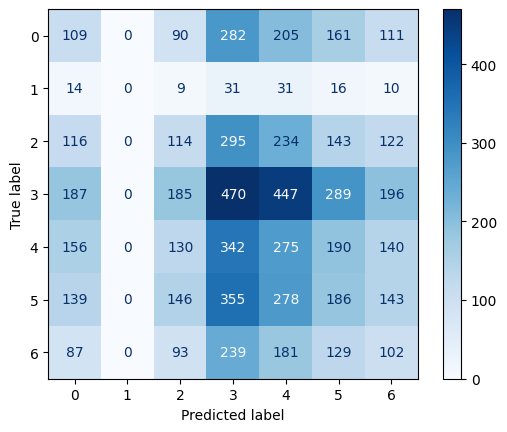

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.13      0.11      0.12       958
           1       0.00      0.00      0.00       111
           2       0.15      0.11      0.13      1024
           3       0.23      0.26      0.25      1774
           4       0.17      0.22      0.19      1233
           5       0.17      0.15      0.16      1247
           6       0.12      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}


test_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
test_generator = test_data_gen.flow_from_directory(
        '/content/fed/FED/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# do prediction on test data
predictions = emotion_model.predict_generator(test_generator)

# see predictions
# for result in predictions:
#     max_index = int(np.argmax(result))
#     print(emotion_dict[max_index])

print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")